<a href="https://colab.research.google.com/github/lhfaguiar/CDADOSP2/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciência dos Dados - 2020 / Segundo Semestre

## Projeto 2

## Informações do grupo

Membros:
Carlos Eduardo Abdelmalack Simodo, Lai Aguiar


O trabalho foi realisado em sua maioria utilizando o google colab, no qual os integrantes discutiram em conjunto a maioria das alterações. Apesar de o trabalho ter sido feito em conjunto, o Lai teve uma maior presença na primeira parte do trabalho,ou seja, na limpeza, criacão de graficos , enquanto o Carlos focou na correção de problemas e edição e comentario do documento. Os modelos foram onde o trabalho foi mais discutido.

Fonte de onde foram retirados os dados utilizados no projeot :  https://github.com/seade-R/dados-covid-sp , repositório público com dados da covid no estado de São Paulo


## Introdução

Nesse trabalho, o nosso grupo decidiu aproveitar a grande quantidade de dados sobre a covid-19 para modelar um classificador . Esse classificador tem como objetivo o cálculo da probabilidade de uma pessoa infectada com a Covid-19 falecer, e para isso ele considera as doenças possuídas e o sexo do entrevistado (como iremos nos referir às pessoas cujos dados utilizamos para realizar o projeto). 

## Código


### Imports

In [1]:
import pandas as pd
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


### Limpeza do dataframe

Antes de programarmos um classificador, realizamos uma limpeza no dataset que planejávamos utilizar.  Analisando o dataset, percebemos que algumas das informações presentes nesse não tinham relevância para o projeto. Alem disso, também decidimos excluir entrevistados cujas informações não estavam completas, para não apenas aumentar a acurácia dos dados coletados, mas também para reduzir o tamanho do dataframe (que inicialmente possuía mas de 1milhão de entrevistados). 

In [2]:
data = pd.read_csv('casos_obitos_doencas_preexistentes.csv', sep=';')


# Eliminamos a coluna codigo_ibge por ela não nos trazer uma informação relevante,
# já que decidimos trabalhar apenas com   comorbidades, idade, sexo 
del data['codigo_ibge']

# Eliminamos as linhas da tabela onde temos informações repetidas e 
# incoerentes como idade = 120 anos
# Também eliminamos todos identificadores IGNORADO ou vazios
data = data[data['idade'] < 120]

data = data.applymap(lambda x: np.nan if x == 'IGNORADO' else x).dropna()
# data = data[data != np.nan()]
# data = data.replace('IGNORADO', 'NÃO')
# data = data.replace('NaN', 'NÃO')

#data.to_csv('casos_obitos_doencas_preexistentes_tratado.csv', sep=';')

Com a limpeza concluida, separamos os dados em um dataframe de teste e um de treino, e prosseguimos para a próximo etapa.

In [3]:
data_copy = data.copy()
train = data_copy.sample(frac=0.75, random_state=0)
test = data_copy.drop(train.index)

### Análise Inicial

Para termos uma melhor ideia dos dados com que estamos trabalhando, decidimos realizar uma análise superficial dos dados. 
A primaira parte analisada por nos foram os entrevistados. Para isso, decidimos estudar a idade, uma vez que ela é o único dado que presente em todos.


In [4]:
media_idade = data['idade'].mean()
mediana_idade = data['idade'].median()
moda_idade = data['idade'].mode()
var_idade = data['idade'].var()
std_idade = data['idade'].std()

print('A média de idade no nosso dataset é :', media_idade, '')
print('A variância da idade no nosso dataset é: ', var_idade)
print('O desvio padrão da idade no nosso dataset é: ', std_idade, 'que significa que os dados não estão muito espalhados')
print('A mediana da idade no nosso dataset é: ', mediana_idade)
print('A moda de idade no nosso dataset é: ', moda_idade, 'uma idade alta muito frequente')

A média de idade no nosso dataset é : 62.893096629986246 
A variância da idade no nosso dataset é:  269.35122106814043
O desvio padrão da idade no nosso dataset é:  16.41192313740655 que significa que os dados não estão muito espalhados
A mediana da idade no nosso dataset é:  64.0
A moda de idade no nosso dataset é:  0    67.0
dtype: float64 uma idade alta muito frequente


#### Para realizar essa análise, verificamos não apenas a média das idades, como tambem a meidana e a moda. Fizemos isso pois queriamos evitar a influencia dos outliers. Percebemos que tanto a idade média quanto a mediana e a moda estão muito altas, indicando que a maioria dos entrevistados realmente possuem idades elevadas. Com um melhor entendimento dos entrevistados, decidimos partir para as comorbidades, sendo que elas copoem a maior parte dos dados analisados.

In [5]:
data_temp = data.replace({'NÃO': 0, 'SIM': 1})
print(data_temp.corr())

                            idade     obito  ...  puerpera  sindrome_de_down
idade                    1.000000  0.297827  ... -0.079747         -0.038365
obito                    0.297827  1.000000  ... -0.025594         -0.001013
asma                    -0.105307 -0.040101  ...  0.007501          0.014850
cardiopatia              0.230536  0.069318  ... -0.039510         -0.014788
diabetes                 0.092998  0.046980  ... -0.017723         -0.006785
doenca_hematologica     -0.015454  0.018749  ...  0.000988          0.062531
doenca_hepatica         -0.008573  0.038744  ...  0.003247          0.079719
doenca_neurologica       0.149763  0.109948  ... -0.008948          0.023834
doenca_renal             0.039058  0.093995  ... -0.002968          0.006670
imunodepressao          -0.048770  0.044293  ... -0.006931          0.024347
obesidade               -0.170742 -0.010129  ... -0.008326          0.010757
outros_fatores_de_risco  0.015578  0.047074  ... -0.015972         -0.000672

#### Plotamos inicialmente uma matriz de correlação, pois com ela podemos visualizar a correlação entre as doencas e o obito. Percebemos que a variavel que possui a maior correlação com o óbito é a idade,  algo que ja esperavamos, mas não tinhamos como comprovar. Tambem esperavamos uma correlação mais alta da pneumopatia com o obto, uma vez que ela é uma doença respiratoria, mas segundo a matriz ela não possui tanta correlação quanto o esperado.

#### Verificando que as correlações são muito baixas, percebemos que por lidarmos com variaveis binarias, a correlação se torna uma análise infrutifera, logo abandonamos a anãlise de correlação e dos graficos de scatterplor, que planejavamos utilizar. Decidimos então analisar a prevalencia das doenças nos entrevistados, uma vez que ela está diretamente relacionada com a probabilidade de ter cada doença. Para isso utilizamos gráficos de setores(pizza), pois apesar de não ofereceram análises complexas, nos permitem ter uma ideia mais geral da situação,e esse é o nosso objetivo nessa análise.

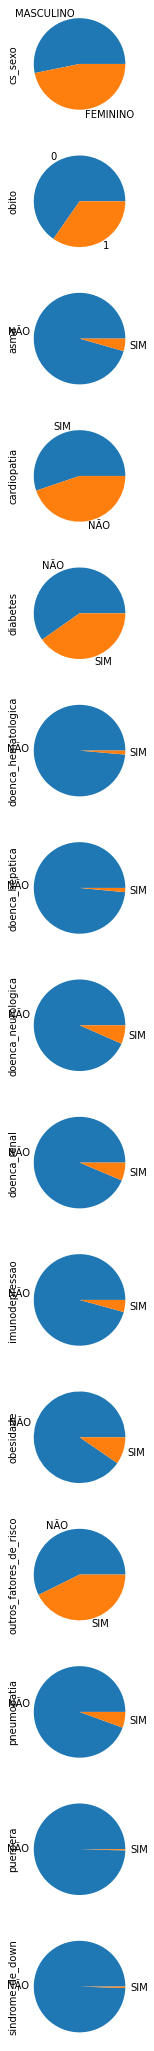

In [6]:
plt.figure()
i=1
#print(data.columns)
#lista para retirar dados que não pertecem a essa parte da analise
lista_no_plot = ['nome_munic', 'idade', 'data_inicio_sintomas','diagnostico_covid19']
for item in data.columns:
  if item not in (lista_no_plot):
    a = plt.subplot(16,1,i)
    temp_frame = data[item].value_counts()
    plot = temp_frame.plot.pie(y=item, figsize=(40, 40),ax=a)
    i+=1
  

#### Com os dados obtidos acima, fomos capazes de obter uma noção: do perfil dos pacientes,que possuem em media uma idade mais elevada e são em sua maioria homens, da prevalencia das doenças,sendo a mais comum a cardiopatia, e a correlação que essas doencas posssuem com a morte, que afetou cerca de um terço dos entrevistados. Com isso, decidimos que possuimos informações o suficiente para entender superficialmente os dados, e começamos a criação do modelo.

### Primeiro Modelo

Para o nosso modelo, decidimos criar um Naive Bayes. Entre os motivos pelos quais decidimos optar por esso modelo, estão o fato de que no mundo da medicina ele costuma ser o mais utilizado como uma primeira analise, e que nos ja possuiamos experiencia lidando com esse classificador. O Naive Bayes é um classificador que parte do principio de que todas as variaveis são independentes, e embora não seja o mais elaborado dos classificadores, é um muito presente em análise de dados. (link sobre o uso do naive bayes na área médica: http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0303-76572019000101401).

Para criar um classificador desses, é necessario o calculo das porcentagens envolvendo as doenças, e é isso que realizamos a seguir. (Iremos , para facilitação do processo, considerar o sexo como a  uma doença, uma vez que é uma variavel binaria e por acreditarmos que esse agrupamento não influencia negativamente o modelo).

In [7]:
obitou = train[train['obito']==1]
viveu = train[train['obito'] != 1]

# probabilidades de ter cada doenca, dado que morreu
dict_doenca_morreu = dict()
for column in obitou.columns:
    if column not in (lista_no_plot):
        dict_doenca_morreu[column] = len(obitou[obitou[column]=='SIM'])/len(obitou)

# probabilidades de ter cada doenca, dado que sobreviveu
dict_doenca_viveu = dict()
for column in viveu.columns:
    if column not in (lista_no_plot):
        dict_doenca_viveu[column] = len(viveu[viveu[column]=='SIM'])/len(viveu)

# probabilidade de ter cada doenca
dict_doenca = dict()
for column in train.columns:
    if column not in (lista_no_plot):
        dict_doenca[column] = len(train[train[column]=='SIM'])/len(data)

# probabilidade de morrer do covid
prob_morrer = len(obitou)/len(train)
prob_viver = 1 - prob_morrer

# calculo da probabilidade de morrer dado que tem uma doenca
# Aqui foi calculada a probabilidade independente, porém sabemos que não é o cálculo definitivo,pois precisamos da probabilidade combinada
prob_bayes = dict()
for doenca in train.columns:
    if doenca not in (lista_no_plot):
        if dict_doenca[doenca]>0:
            prob_bayes[doenca] = dict_doenca_morreu[doenca]*prob_morrer / dict_doenca[doenca]
        else: prob_bayes[doenca] = 0

Com as probabilidades já calculadas, pudemos criar um modelo simplificado, que nos permitiu testar a funcionabilidade de nosso modelo.

In [8]:
# prob final
def calcula(lista_doenca):
    multip = prob_morrer
    cte_normalizadora_v = prob_viver
    cte_normalizadora_m = prob_morrer

    for doenca in lista_doenca:
        multip = multip*dict_doenca_morreu[doenca]
        cte_normalizadora_v  = cte_normalizadora_v*dict_doenca_viveu[doenca]
        cte_normalizadora_m  = cte_normalizadora_m*dict_doenca_morreu[doenca]
    
    cte_normalizadora = cte_normalizadora_v + cte_normalizadora_m
    prob_final = multip/cte_normalizadora

    return prob_final

#Teste da função de calculo da probabilidade de óbito

pacientes = {'paciente 1': ['cardiopatia', 'pneumopatia'],
            'paciente 2': ['asma', 'diabetes', 'imunodepressao', 'cardiopatia'],
            'paciente 3': ['pneumopatia']}


for paciente in pacientes.keys():
    print("A probabilidade do {} morrer, dado que ele tem {} é de {}".format(paciente, str(pacientes[paciente])[1:-1].replace("""'""", ""), calcula(pacientes[paciente])))


df = test
test['Probabilidade']=0
test['Classificacao']=0
columns = data.columns

lista_prob=[]

for index, row in df.iterrows(): 
    lista_variaveis = []
    row['prob'] = 0
    for column in columns:
       if column not in lista_no_plot:
            if row[column] == 'SIM':
              lista_variaveis.append(column)
    lista_prob.append(float(calcula(lista_variaveis)))

df['Probabilidade'] = lista_prob

#def verifica_morte(prob):
#  alfa=0.559
#  if prob>alfa:
#    return 'SIM'
#  else:
#    return 'NÃO'


# alfa = 0.7
# df["Classificacao"] = df["Probabilidade"].apply(verifica_morte)
# df

A probabilidade do paciente 1 morrer, dado que ele tem cardiopatia, pneumopatia é de 0.5376343640177182
A probabilidade do paciente 2 morrer, dado que ele tem asma, diabetes, imunodepressao, cardiopatia é de 0.3900032672954768
A probabilidade do paciente 3 morrer, dado que ele tem pneumopatia é de 0.5076687116564418


Com o modelo de teste pronto, observamos que o classificador foi capaz de considerar diversas doenças pré-existentes. Decidimos não preparar o modelo para valores desconhecidos, pois o modelo trabalha com variaveis binarias, e informações que não eram conhecidas foram retiradas na limepza do dataset, o modelo teoricamente não teria problemas em relação a isso.

Com a probabilidade de obito já calculada, decidimos prosseguir para a verificação do obito. Essa etapa consistiu na descoberta de uma constante que serviria de parametro para o classificador, sendo que os testes com probabilidades maiores que esse parametro seriam considerados como obitos, e os testes com menores como não obitos. 

A obtenção dessa constante foi feita por meio de testes, em que o computador iria comparar probabilidades calculadas com diferentes constantes, comparando o resultado com os dados do dataframe.

In [9]:
def verifica_alfa(prob):
  if prob>alfa:
    return 'SIM'
  else:
    return 'NÃO'

alfa = 0.05
delta = 0.01
melhor = [alfa, 0]
accur = 0.0

while alfa <= 1.0:
  df["Classificacao"] = df["Probabilidade"].apply(verifica_alfa)
  df = df.replace({0: 'NÃO', 1: 'SIM'})
  #cross_tab = pd.crosstab(df.obito,df.Classificacao, normalize="columns")*100
  
  acerto = df[df['obito']==df['Classificacao']]
  accur = round(len(acerto)/len(df), 3)*100

  if accur > melhor[1]:
    melhor = [alfa, round(accur, 3)]  

  #print('Para o threshold {} a acurácia do modelo é de {}%'.format(alfa, accur))

  alfa += delta

print(melhor)

[0.5400000000000003, 66.5]


Com o modelo pronto, decidimos plotar uma matriz de confusão para comparar nossas previsõe com os dados.

In [10]:
# Calculo das probabilidades com o dataset de teste
df = df.replace({0: 'NÃO', 1: 'SIM'})
pd.crosstab(df.obito,df.Classificacao, normalize="columns")*100


Classificacao,NÃO
obito,
NÃO,65.061898
SIM,34.938102


### Modelo 2

Com a constate ja calculada , o nosso primeiro modelo ja está pronto. Como não estavamos satisfeitos com os resultados dele, decidimos criar um novo, dessa vez utilizando outras tecnicas de modelagem.

O modelo consiste em uma regressão linear, um modelo utilizado em sala de aula, que  tem como objectivo tratar de um valor que não se consegue estimar inicialmente.

Para criar esse classificador , é necessario definir as colunas que serão utilizadas. Nesse classificador decidimos utilizar colunas que foram ignoradas no primeiro modelo, esperando aumentar a precisão. 

Durante a criação do modelo, tivemos problemas para terminar o classificados, e acabamos tendo que recorrer a um site externo(https://stats.stackexchange.com/questions/89914/building-a-classification-model-for-strictly-binary-data) , o qual nos ajudou a corrigir nossos erros. 



In [16]:
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LinearRegression

data_copy = data.copy()
train = data_copy.sample(frac=0.75, random_state=0)
test = data_copy.drop(train.index)

X_test = test.replace({'NÃO': 0, 'SIM': 1})
Y_test = test['obito']
del X_test['obito']
del X_test['nome_munic']
del X_test['cs_sexo']
del X_test['diagnostico_covid19']
del X_test['data_inicio_sintomas']

X_train = train.replace({'NÃO': 0, 'SIM': 1})
Y_train = X_train['obito']
del X_train['obito']
del X_train['nome_munic']
del X_train['cs_sexo']
del X_train['diagnostico_covid19']
del X_train['data_inicio_sintomas']


#Cria um classificador 
clf = svm.SVC(kernel='linear') # Linear Kernel

#Treina o modelo usando os dados determinados previamente
clf.fit(X_train, Y_train)

Accurácia: 0.65517537826685
Precisão: 0.5357624831309041


Com a parte de treino pronta, pudemos aplicar o modelo no nosso dataframe de teste

In [ ]:
#Realiza a previsao no conjunto de teste
Y_pred = clf.predict(X_test)

print("Accurácia:",metrics.accuracy_score(Y_test, Y_pred))

# Precisão do modelo : quantas das classificações de classe Positivo que o modelo fez estão corretas?
print("Precisão:",metrics.precision_score(Y_test, Y_pred))

Esse modelo, diferentemente do primeiro, leva em consideração não apenas, as comorbidades e o sexo, como tambem o local onde foi examinado o entrevistado e a data de contagio. Esperavamos que esse modelo fosse mais preciso que o outro, uma vez que considera mais caracteristicas que não implementamos no primeiro. Entretanto, sua acurácia se demonstrou similar à do primeiro, e além disso com o aprofundamento do nosso conhecimento sobre o assunto, percebemos que esse tipo de modelo funciona melhor para variveis continuas. 

## Conclusão

Devido à semelhante performance demonstrada por ambos os modelos, e aos problemas de adequação do modelo 2, decidimos utilizar o modelo 1, uma vez que ele se adequa melhor ao assunto analisado.